In [281]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import PIL
from tqdm.notebook import tqdm
from pytube import Channel
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer 
from nltk.corpus import stopwords

In [282]:
# set up the natural language toolkit - probably overkill using this for this project
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chrisgreening/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/chrisgreening/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [283]:
# we'll cached the channel vidoes in a json file with this name
CHANNEL_NAME = "luni"
# the channel URL
CHANNEL_URL = "https://www.youtube.com/c/bitlunislab"
# how many videos to run against - more videos may give better stats
# but you'll be going further back in time so may be less relevant...
MAX_VIDEOS = 300

In [284]:
def get_video_stats(name, channel_url):
    print("Downloading video stats - this may take some time for a large channel")
    # check to see if we've cached this channel already
    if os.path.exists(name+".json"):
        print("Using the cached results")
        # if we have, load the cache
        with open(name+".json", "r") as f:
            videos = json.load(f)
            return videos
    channel = Channel(channel_url)
    videos = channel.videos
    print("Extracting data from "+str(len(videos))+" videos")
    video_data = [{
        "title": video.title,
        "thumbnail": video.thumbnail_url,
        "description": video.description,
        "publish_date": video.publish_date,
        "views": video.views,
        "length": video.length
    } for video in tqdm(videos[0:min(len(videos), MAX_VIDEOS)])]
    # cache the results
    with open(name+".json", "w") as f:
        json.dump(video_data, f, indent=4, sort_keys=True, default=str)
    return video_data

In [285]:
videos = get_video_stats(CHANNEL_NAME, CHANNEL_URL)

Using the cached results


In [286]:
# convert the array of videos to a pandas dataframe
videos_df = pd.DataFrame(videos)
videos_df.head()

,description,length,publish_date,thumbnail,title,views
0,I was bored! All my other projects end up drag...,481,2022-05-08 00:00:00,https://i.ytimg.com/vi/KNjdy0BIPbk/hqdefault.jpg,DIY Pocket Bike in 24h,18901
1,"Starlink, Medical Ultrasound, 5G and my DIY so...",869,2022-02-19 00:00:00,https://i.ytimg.com/vi/z4uxC7ISd-c/sddefault.jpg,DIY sonar scanner (practical experiments),381540
2,Maker Cast is a monthly live show with amazing...,8925,2022-01-02 00:00:00,https://i.ytimg.com/vi/JzrIxwUo3Xw/sddefault.jpg,Maker Cast Episode 36,5038
3,I got a flip dot display from the viewer and t...,762,2021-11-07 00:00:00,https://i.ytimg.com/vi/8DvH6FiS3sg/sddefault.jpg,Worst Oscilloscope in the World (DIY & Flip Do...,49140
4,"Sponsor: $2 for 1-4 Layer PCBs, sign up to get...",635,2021-08-16 00:00:00,https://i.ytimg.com/vi/HEM04lS2R-Y/sddefault.jpg,6 LED Projectors driven by a single ESP32 = VG...,258614


# Histogram of views

(array([44., 14., 15., 10.,  8., 11.,  5.,  2.,  3.,  4.,  0.,  1.,  1.,
         2.,  0.,  0.,  0.,  2.,  1.,  1.]),
 array([  2953.  ,  21882.35,  40811.7 ,  59741.05,  78670.4 ,  97599.75,
        116529.1 , 135458.45, 154387.8 , 173317.15, 192246.5 , 211175.85,
        230105.2 , 249034.55, 267963.9 , 286893.25, 305822.6 , 324751.95,
        343681.3 , 362610.65, 381540.  ]),
 <BarContainer object of 20 artists>)

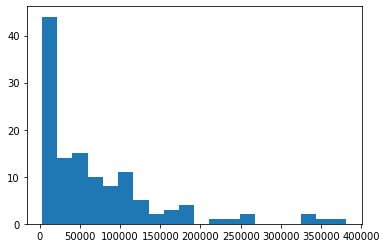

In [287]:
# ignore the outliers by removing videos in top and bottom 5% percentiles
filtered = videos_df[
    (videos_df.views >= videos_df.views.quantile(0.05))
    &
    (videos_df.views <= videos_df.views.quantile(0.95))
]
# plt.hist(videos_df['views'], bins=20, range=(0, 200000))
plt.hist(filtered['views'], bins=20)

In [288]:
def get_title_words(videos):
    clean_titles = [
        title for title in videos.title 
        if 'maker cast' not in title.lower() and 'makercast' not in title.lower()
    ]
    titles = " ".join(clean_titles).lower()
    words = word_tokenize(titles)
    words = [word for word in words if not word in stopwords.words()]

    # probably not needed really
    # stem the words
    # stemmer = SnowballStemmer("english")
    # words = [stemmer.stem(word) for word in words]

    #  get rid of any "'s" at the end of words
    words = [word.replace("'s", "") for word in words]
    return " ".join(words)

In [289]:
def plot_wordcloud(text):
    wordcloud = WordCloud(collocations=False).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

# Word cloud of top 25% of videos

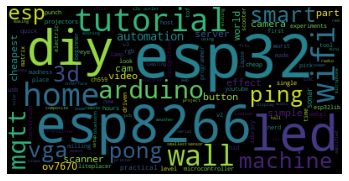

In [290]:
top = videos_df[videos_df.views >= videos_df.views.quantile(0.75)]
words = get_title_words(top)
plot_wordcloud(words)

# Word cloud of bottom 25% of videos

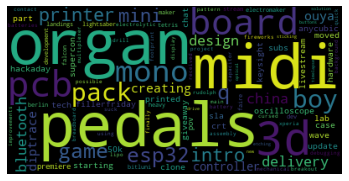

In [291]:
bottom = videos_df[videos_df.views <= videos_df.views.quantile(0.25)]
words = get_title_words(bottom)
plot_wordcloud(words)

In [292]:
# top 10 titles
videos_df.sort_values(by='views', ascending=False)[['title', 'views']].head(10)

,title,views
20,The Cheapest CNC Milling Machine,2107813
43,DIY LED Video Wall made in 24 hours,917276
18,Ping Pong LED Wall v3,726397
92,The Smallest WiFi Button in the World (ESP8266...,696782
95,Home automation over WiFi using WeMos ESP8266,636688
36,DIY Ping Pong LED Wall v2.0,551260
94,Remote power outlet home automation tutorial E...,382331
1,DIY sonar scanner (practical experiments),381540
105,Arduino audio sampling tutorial (part 1),359581
83,"ESP32 with Camera and TFT Display (OV7670, FIFO)",339342


In [293]:
# bottom 10 titles
videos_df.sort_values(by='views', ascending=False)[['title', 'views']].tail(10)

,title,views
38,Maker Cast S01E07,3878
121,MIDI organ pedals - 02: More background,3869
111,Mini project: Rudolph,2953
57,50k subs Q&A and Chat !!!LIVESTREAM!!!🎉🎊⚡ (not...,2907
137,My new optical drive,2836
71,Maker Faire Berlin,2828
109,Electrolytic capacitor fireworks,2800
125,Drill Batteries Suck,2015
128,Delivery from China - Xperia Mini Display,1229
134,Finally received my Ouya controllers,845


In [294]:
def show_images(urls):
    plt.figure(figsize=(20,10))
    columns = 5
    for i, url in enumerate(urls):
        with urllib.request.urlopen(url) as f:
            img = plt.imread(f, format="jpg")
            plt.subplot(int(len(urls) / columns + 1), columns, i + 1)
            plt.axis('off')
            plt.imshow(img)

# Top 10 thumbnails

In [295]:

thumbs = videos_df.sort_values(by='views', ascending=False)['thumbnail'].head(10)
show_images(thumbs)

# Bottom 10 thumbnails

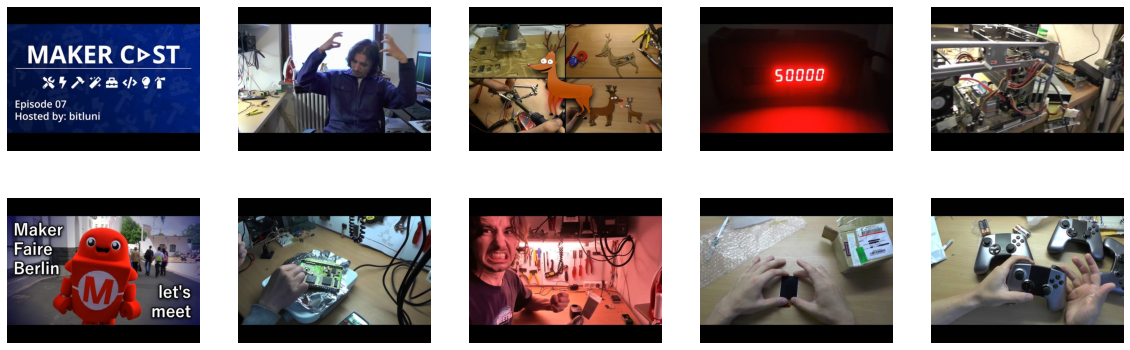

In [ ]:
thumbs = videos_df.sort_values(by='views', ascending=False)['thumbnail'].tail(10)
show_images(thumbs)